In [1]:
pip install git+https://github.com/JerzyKultura/Jerzy.git

  Cloning https://github.com/JerzyKultura/Jerzy.git to /tmp/pip-req-build-gdempo94
  Running command git clone --filter=blob:none --quiet https://github.com/JerzyKultura/Jerzy.git /tmp/pip-req-build-gdempo94
  Resolved https://github.com/JerzyKultura/Jerzy.git to commit cddf7c22ce781fe707178bc5aa086a377c89a3d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install yfinance

In [3]:
from jerzy import *

In [14]:
# Enhanced Financial Analysis System using Teeno Framework
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import os
import tempfile
import logging
from io import BytesIO
import base64
import os
import IPython
import tempfile
from typing import Dict, List, Any, Optional, Union


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)

# DeepInfra configuration
DEEPINFRA_API_KEY = "6rdEEEr8WLCOp1mMdS3MTgPgT9A9IRSw"
DEEPINFRA_MODEL = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"

# Create LLM instance with AuditTrail for transparency
llm = OpenAILLM(
    api_key=DEEPINFRA_API_KEY,
    model=DEEPINFRA_MODEL,
    base_url="https://api.deepinfra.com/v1/openai"
)

# Set up audit trail with storage path
audit_trail = AuditTrail(storage_path="/content/audit_trails")


# **Adding the necessary functions**

In [17]:

@robust_tool(retries=3, wait_seconds=1.0)
@log_tool_call("get_stock_price")
def get_stock_price(symbol="AAPL", period="1d"):
    """Get the current stock price and recent price history."""
    try:
        logging.info(f"📊 Retrieving stock price for {symbol} over {period}...")
        stock = yf.Ticker(symbol)
        hist = stock.history(period=period)

        if hist.empty:
            return {
                "status": "error",
                "error": f"No data found for {symbol}",
                "symbol": symbol
            }

        # Get the latest price and basic stats
        latest_price = hist['Close'].iloc[-1]
        starting_price = hist['Close'].iloc[0]
        change = latest_price - starting_price
        change_percent = (change / starting_price) * 100

        return {
            "status": "success",
            "result": {
                "symbol": symbol,
                "latest_price": round(latest_price, 2),
                "change": round(change, 2),
                "change_percent": round(change_percent, 2),
                "period": period,
                "date": hist.index[-1].strftime("%Y-%m-%d"),
                "volume": int(hist['Volume'].iloc[-1]) if 'Volume' in hist else None
            }
        }
    except Exception as e:
        logging.error(f"❌ Error retrieving stock price: {str(e)}")
        return {
            "status": "error",
            "error": str(e),
            "symbol": symbol
        }

@robust_tool(retries=2)
@log_tool_call("get_price_change_percent")
def get_price_change_percent(symbol="AAPL", days_ago=30):
    """Calculate the percentage change in price over a specific period."""
    try:
        logging.info(f"📉 Calculating price change for {symbol} over {days_ago} days...")
        ticker = yf.Ticker(symbol)

        # Get today's date
        end_date = datetime.now()

        # Get the date N days ago
        start_date = end_date - timedelta(days=int(days_ago))

        # Convert dates to string format that yfinance can accept
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = end_date.strftime('%Y-%m-%d')

        # Get the historical data
        historical_data = ticker.history(start=start_date, end=end_date)

        if historical_data.empty or len(historical_data) < 2:
            return {
                "status": "error",
                "error": f"Insufficient data for {symbol} over {days_ago} days",
                "symbol": symbol
            }

        # Get the closing price N days ago and today's closing price
        old_price = historical_data['Close'].iloc[0]
        new_price = historical_data['Close'].iloc[-1]

        # Calculate the percentage change
        percent_change = ((new_price - old_price) / old_price) * 100

        return {
            "status": "success",
            "result": {
                "symbol": symbol,
                "days_ago": days_ago,
                "old_price": round(old_price, 2),
                "new_price": round(new_price, 2),
                "percent_change": round(percent_change, 2),
                "start_date": historical_data.index[0].strftime('%Y-%m-%d'),
                "end_date": historical_data.index[-1].strftime('%Y-%m-%d')
            }
        }
    except Exception as e:
        logging.error(f"❌ Error calculating price change: {str(e)}")
        return {
            "status": "error",
            "error": str(e),
            "symbol": symbol
        }

def fallback_compare_stocks(symbols=["AAPL", "MSFT"], period="1mo"):
    """Fallback method for comparing stocks when primary method fails."""
    logging.warning("Using fallback stock comparison method with basic data")
    results = {}

    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            # Just get the latest price as a basic fallback
            latest_data = stock.history(period="1d")
            if not latest_data.empty:
                results[symbol] = {
                    "latest_price": round(latest_data['Close'].iloc[-1], 2),
                    "note": "Using fallback method with limited data"
                }
            else:
                results[symbol] = {"error": f"No data available for {symbol}"}
        except Exception as e:
            results[symbol] = {"error": f"Fallback error: {str(e)}"}

    return {
        "status": "partial_success",
        "result": results,
        "message": "Used fallback method with limited comparison capabilities"
    }

@with_fallback(fallback_compare_stocks)
@log_tool_call("compare_stocks")
def compare_stocks(symbols=["AAPL", "MSFT"], period="1mo"):
    """Compare performance of multiple stocks over a period."""
    try:
        # Ensure symbols is a list, even if it comes in as a string
        if isinstance(symbols, str):
            # Check if it's a JSON string and parse it
            if symbols.startswith('[') and symbols.endswith(']'):
                try:
                    symbols = json.loads(symbols)
                except json.JSONDecodeError:
                    symbols = [symbols]  # If not valid JSON, treat as a single symbol
            else:
                symbols = [symbols]  # Single symbol as string

        logging.info(f"🔍 Comparing stocks: {', '.join(symbols)} over {period}...")
        results = {}

        for symbol in symbols:
            stock = yf.Ticker(symbol)
            hist = stock.history(period=period)

            if hist.empty:
                results[symbol] = {"error": f"No data found for {symbol}"}
                continue

            latest_price = hist['Close'].iloc[-1]
            starting_price = hist['Close'].iloc[0]
            change = latest_price - starting_price
            change_percent = (change / starting_price) * 100

            results[symbol] = {
                "latest_price": round(latest_price, 2),
                "starting_price": round(starting_price, 2),
                "change": round(change, 2),
                "change_percent": round(change_percent, 2),
                "start_date": hist.index[0].strftime('%Y-%m-%d'),
                "end_date": hist.index[-1].strftime('%Y-%m-%d')
            }

        # Add comparison analysis
        if len(results) > 1:
            symbols_with_data = [s for s in symbols if s in results and "error" not in results[s]]

            if symbols_with_data:
                best_performer = max(symbols_with_data, key=lambda x: results[x]["change_percent"])
                worst_performer = min(symbols_with_data, key=lambda x: results[x]["change_percent"])

                results["analysis"] = {
                    "best_performer": {
                        "symbol": best_performer,
                        "change_percent": results[best_performer]["change_percent"]
                    },
                    "worst_performer": {
                        "symbol": worst_performer,
                        "change_percent": results[worst_performer]["change_percent"]
                    },
                    "period": period
                }

        return {
            "status": "success",
            "result": results
        }
    except Exception as e:
        logging.error(f"❌ Error comparing stocks: {str(e)}")
        return {
            "status": "error",
            "error": str(e)
        }


@log_tool_call("generate_stock_chart")
def generate_stock_chart(symbols=["AAPL"], period="1mo", interval="1d", chart_type="line"):
    """Generate and display a chart for one or more stocks in the Colab notebook."""
    try:
        # Import IPython display for notebook rendering
        from IPython.display import display, HTML
        import base64

        # Create the plot
        plt.figure(figsize=(10, 6))

        # Get data for each symbol
        for symbol in symbols:
            stock = yf.Ticker(symbol)
            hist = stock.history(period=period, interval=interval)

            if hist.empty:
                continue

            if chart_type == "line":
                plt.plot(hist.index, hist['Close'], label=symbol)
            elif chart_type == "candle":
                # Simple candlestick approximation
                colors = ['red' if close < open else 'green' for open, close in zip(hist['Open'], hist['Close'])]
                plt.bar(hist.index, hist['Close'] - hist['Open'], bottom=hist['Open'], color=colors, alpha=0.5, width=0.8)
                plt.plot(hist.index, hist['Close'], color='black', alpha=0.5)

        plt.title(f"Stock Price - {', '.join(symbols)} ({period})")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Save to a bytes buffer
        from io import BytesIO
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)

        # Encode the image to base64
        image_base64 = base64.b64encode(buffer.getvalue()).decode()
        plt.close()

        # Create an HTML img tag to display the image
        html = f'<img src="data:image/png;base64,{image_base64}"/>'
        display(HTML(html))

        return {
            "status": "success",
            "result": {
                "display_method": "inline in notebook",
                "symbols": symbols,
                "period": period,
                "type": chart_type
            }
        }
    except Exception as e:
        logging.error(f"❌ Error generating chart: {str(e)}")
        return {
            "status": "error",
            "error": str(e)
        }

@log_tool_call("monte_carlo_simulation")
def monte_carlo_simulation(symbol: str, days: int = 20, num_simulations: int = 1000):
    """
    Run Monte Carlo simulation to forecast stock prices.

    Args:
        symbol: Stock ticker symbol
        days: Number of days to simulate forward
        num_simulations: Number of simulation paths to generate

    Returns:
        Dict with simulation results and statistics
    """
    try:
        print(f"🔮 Running Monte Carlo simulation for {symbol} ({days} days, {num_simulations} paths)...")

        # Convert string inputs to integers if needed
        days = int(days) if isinstance(days, str) else days
        num_simulations = int(num_simulations) if isinstance(num_simulations, str) else num_simulations

        # Fetch historical data (last 252 trading days ≈ 1 year)
        ticker = yf.Ticker(symbol)
        hist = ticker.history(period="1y")

        # Check if we have data
        if hist.empty:
            return {
                "error": f"No historical data found for symbol {symbol}",
                "symbol": symbol
            }

        # Calculate daily returns
        hist['Returns'] = hist['Close'].pct_change()

        # Remove NaN values
        returns = hist['Returns'].dropna()

        if returns.empty:
            return {
                "error": f"Insufficient return data for symbol {symbol}",
                "symbol": symbol
            }

        # Calculate mean and standard deviation of returns
        mean_return = returns.mean()
        std_return = returns.std()

        # Get the last closing price
        last_price = hist['Close'].iloc[-1]

        # Generate random returns for simulation
        # Shape: (num_simulations, days)
        random_returns = np.random.normal(mean_return, std_return, size=(num_simulations, days))

        # Initialize price paths
        price_paths = np.zeros((num_simulations, days + 1))
        price_paths[:, 0] = last_price  # Start all paths at last known price

        # Generate price paths
        for day in range(1, days + 1):
            price_paths[:, day] = price_paths[:, day - 1] * (1 + random_returns[:, day - 1])

        # Extract final prices (last day of simulation)
        final_prices = price_paths[:, -1]

        # Calculate statistics
        current_price = float(last_price)
        mean_final_price = float(np.mean(final_prices))
        median_final_price = float(np.median(final_prices))
        std_final_price = float(np.std(final_prices))

        # Calculate percentiles
        percentiles = np.percentile(final_prices, [5, 25, 75, 95])

        # Calculate probability of positive return
        positive_returns = np.sum(final_prices > current_price)
        prob_positive = float(positive_returns / num_simulations)

        # Expected return
        expected_return = (mean_final_price - current_price) / current_price

        # Create date range for the simulation period
        last_date = hist.index[-1]
        future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=days)

        result = {
            "symbol": symbol,
            "current_price": current_price,
            "simulation_days": days,
            "num_simulations": num_simulations,
            "statistics": {
                "mean_final_price": mean_final_price,
                "median_final_price": median_final_price,
                "std_final_price": std_final_price,
                "expected_return_pct": expected_return * 100,
                "probability_positive_return": prob_positive
            },
            "percentiles": {
                "5th": float(percentiles[0]),
                "25th": float(percentiles[1]),
                "75th": float(percentiles[2]),
                "95th": float(percentiles[3])
            },
            "price_range": {
                "min": float(np.min(final_prices)),
                "max": float(np.max(final_prices))
            },
            "historical_stats": {
                "mean_daily_return": float(mean_return),
                "daily_volatility": float(std_return),
                "annualized_volatility": float(std_return * np.sqrt(252))
            },
            "simulation_end_date": future_dates[-1].strftime("%Y-%m-%d"),
            "confidence_intervals": {
                "90_percent": [float(percentiles[0]), float(percentiles[3])],
                "50_percent": [float(percentiles[1]), float(percentiles[2])]
            }
        }

        print(f"✅ Simulation completed successfully!")
        print(f"📈 Current price: ${current_price:.2f}")
        print(f"📊 Mean predicted price: ${mean_final_price:.2f}")
        print(f"🎯 Expected return: {expected_return*100:.2f}%")
        print(f"📉 90% confidence interval: ${percentiles[0]:.2f} - ${percentiles[3]:.2f}")

        return result

    except Exception as e:
        error_msg = f"Error running Monte Carlo simulation: {str(e)}"
        print(f"❌ {error_msg}")
        return {
            "error": error_msg,
            "symbol": symbol
        }



@log_tool_call("get_stock_fundamentals")
def get_stock_fundamentals(symbol="AAPL"):
    """Get fundamental data for a stock."""
    try:
        logging.info(f"📚 Retrieving fundamental data for {symbol}...")
        stock = yf.Ticker(symbol)
        info = stock.info

        # Extract key fundamentals
        fundamentals = {
            "symbol": symbol,
            "name": info.get("shortName", "N/A"),
            "sector": info.get("sector", "N/A"),
            "industry": info.get("industry", "N/A"),
            "market_cap": info.get("marketCap", "N/A"),
            "pe_ratio": info.get("trailingPE", "N/A"),
            "forward_pe": info.get("forwardPE", "N/A"),
            "peg_ratio": info.get("pegRatio", "N/A"),
            "dividend_yield": round(info.get("dividendYield", 0) * 100, 2) if info.get("dividendYield") else "N/A",
            "eps": info.get("trailingEps", "N/A"),
            "beta": info.get("beta", "N/A"),
            "52wk_high": info.get("fiftyTwoWeekHigh", "N/A"),
            "52wk_low": info.get("fiftyTwoWeekLow", "N/A")
        }

        return {
            "status": "success",
            "result": fundamentals
        }
    except Exception as e:
        logging.error(f"❌ Error retrieving fundamentals: {str(e)}")
        return {
            "status": "error",
            "error": str(e),
            "symbol": symbol
        }

# ==========================================
# System tools for transparency and monitoring
# ==========================================

def get_cache_status(agent, detail_level="summary"):
    """Return information about the current cache state."""
    cache_entries = []
    total_size = 0

    for key, (result, timestamp) in agent.cache.cache.items():
        # Calculate approximate size of cached result
        size_bytes = len(json.dumps(result))
        total_size += size_bytes

        if detail_level == "full":
            # Extract tool name and args from key
            parts = key.split(':', 1)
            tool_name = parts[0]
            args = json.loads(parts[1]) if len(parts) > 1 else {}

            age_seconds = time.time() - timestamp
            cache_entries.append({
                "tool": tool_name,
                "args": args,
                "size_bytes": size_bytes,
                "cached_at": datetime.fromtimestamp(timestamp).strftime("%Y-%m-%d %H:%M:%S"),
                "age_seconds": int(age_seconds)
            })

    if detail_level == "summary":
        return {
            "status": "success",
            "result": {
                "entries_count": len(agent.cache.cache),
                "max_size": agent.cache.max_size,
                "ttl_seconds": agent.cache.ttl,
                "total_size_bytes": total_size
            }
        }
    else:
        return {
            "status": "success",
            "result": {
                "entries_count": len(agent.cache.cache),
                "max_size": agent.cache.max_size,
                "ttl_seconds": agent.cache.ttl,
                "total_size_bytes": total_size,
                "entries": cache_entries
            }
        }

def get_token_usage(agent):
    """Return information about token usage."""
    usage = agent.llm.get_token_usage()
    history = agent.llm.get_token_usage_history()

    # Calculate basic stats from history
    prompt_tokens = sum(entry.get("prompt_tokens", 0) for entry in history)
    completion_tokens = sum(entry.get("completion_tokens", 0) for entry in history)
    total_tokens = prompt_tokens + completion_tokens

    # Approximate cost (using OpenAI rates as example)

    return {
        "status": "success",
        "result": {
            "current_session": {
                "requests_count": len(history),
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "total_tokens": total_tokens
                },
            "last_5_requests": history[-5:] if len(history) >= 5 else history
        }
    }

def get_trace_summary(agent):
    """Get a summary of the execution trace."""
    if hasattr(agent, 'trace'):
        trace_summary = agent.trace.format_trace(format_type="markdown")
        return {
            "status": "success",
            "result": {
                "summary": trace_summary,
                "steps_count": len(agent.memory.history)
            }
        }
    return {
        "status": "error",
        "error": "Trace not available for this agent"
    }


def get_audit_summary(agent):
    """Get a summary of the audit trail if available."""
    if hasattr(agent, 'audit_trail') and agent.audit_trail:
        summary = agent.audit_trail.get_summary()
        return {
            "status": "success",
            "result": summary
        }
    return {
        "status": "error",
        "error": "Audit trail not available for this agent"
    }
'''


def get_audit_summary(agent) -> Dict[str, Any]:
    """
    Return the raw contents of the last `run_complete` entry from the audit trail.
    """
    audit = getattr(agent, "audit_trail", None)
    if not audit:
        return {"status": "error", "error": "Audit trail not available for this agent"}

    entries = getattr(audit, "entries", [])
    if not entries:
        return {"status": "success", "result": {"message": "No audit entries"}}

    # find the last run_complete entry
    run_entries = [e for e in entries if e.get("type") == "run_complete"]
    if not run_entries:
        return {"status": "error", "error": "No run_complete entries found"}

    last_run = run_entries[-1]
    return {
        "status": "success",
        "result": last_run
    }

'''

'\n\n\ndef get_audit_summary(agent) -> Dict[str, Any]:\n    """\n    Return the raw contents of the last `run_complete` entry from the audit trail.\n    """\n    audit = getattr(agent, "audit_trail", None)\n    if not audit:\n        return {"status": "error", "error": "Audit trail not available for this agent"}\n\n    entries = getattr(audit, "entries", [])\n    if not entries:\n        return {"status": "success", "result": {"message": "No audit entries"}}\n\n    # find the last run_complete entry\n    run_entries = [e for e in entries if e.get("type") == "run_complete"]\n    if not run_entries:\n        return {"status": "error", "error": "No run_complete entries found"}\n\n    last_run = run_entries[-1]\n    return {\n        "status": "success",\n        "result": last_run\n    }\n\n'

# **Custom Chain Implementation for Financial Analysis**

In [18]:
class FinancialAnalysisChain(Chain):
    """A specialized chain for financial analysis tasks."""

    def __init__(self, llm, tools):
        super().__init__()
        self.llm = llm
        self.tools = tools

    def extract_tickers(self, context, memory):
        """Extract ticker symbols from user query."""
        try:
            # Directly use LLM to extract tickers
            prompt = f"""Extract stock ticker symbols from the following text.
            If no explicit tickers are mentioned but companies are referenced,
            provide the correct ticker symbols for those companies.

            Text: {context.get("query", "")}

            Return ONLY a comma-separated list of ticker symbols, like: AAPL, MSFT, GOOGL
            If no tickers can be determined, return an empty string.
            """

            response = self.llm.generate(prompt).strip()

            # Split and clean tickers
            tickers = [ticker.strip().upper() for ticker in response.split(',') if ticker.strip()]

            # Default to AAPL if no tickers found
            tickers = tickers if tickers else ['AAPL']

            context["tickers"] = tickers
            memory.add_to_history({
                "role": "system",
                "content": f"Extracted tickers: {tickers}",
                "type": "analysis"
            })
        except Exception as e:
            context["tickers"] = ['AAPL']
            memory.add_to_history({
                "role": "system",
                "content": f"Error extracting tickers, defaulting to AAPL: {str(e)}",
                "type": "error"
            })

        return context

    def determine_time_period(self, context, memory):
        """Determine the time period for analysis."""
        try:
            # Directly determine time period
            prompt = f"""Based on the following query, determine the most appropriate time period for financial analysis.

            Query: {context.get("query", "")}

            Return ONLY one of these options:
            1d, 5d, 1mo, 3mo, 6mo, 1y, 5y

            If no clear time period is specified, return "1mo" as default.
            """

            response = self.llm.generate(prompt).strip()

            # Validate and clean the period
            valid_periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '5y']
            period = response if response in valid_periods else "1mo"

            context["time_period"] = period
            memory.add_to_history({
                "role": "system",
                "content": f"Determined time period: {period}",
                "type": "analysis"
            })
        except Exception as e:
            context["time_period"] = "1mo"
            memory.add_to_history({
                "role": "system",
                "content": f"Error determining time period, using default: 1mo. Error: {str(e)}",
                "type": "error"
            })

        return context

    def identify_analysis_type(self, context, memory):
        """Identify what type of financial analysis is needed."""
        try:
            # Directly determine analysis type
            prompt = f"""Based on the following query, determine the most appropriate type of financial analysis.

            Query: {context.get("query", "")}

            Return ONLY one of these options:
            price, change, comparison, visualization, simulation, fundamentals, comprehensive

            If no clear type can be determined, return "comprehensive".
            """

            response = self.llm.generate(prompt).strip().lower()

            # Validate analysis type
            valid_types = ['price', 'change', 'comparison', 'visualization',
                           'simulation', 'fundamentals', 'comprehensive']
            analysis_type = response if response in valid_types else "comprehensive"

            context["analysis_type"] = analysis_type
            memory.add_to_history({
                "role": "system",
                "content": f"Identified analysis type: {analysis_type}",
                "type": "analysis"
            })
        except Exception as e:
            context["analysis_type"] = "comprehensive"
            memory.add_to_history({
                "role": "system",
                "content": f"Error identifying analysis type, using default: comprehensive. Error: {str(e)}",
                "type": "error"
            })

        return context

    def execute_analysis(self, context, memory):
        """Execute the appropriate analysis based on the identified type."""
        # Ensure clean data
        analysis_type = context.get("analysis_type", "comprehensive")
        tickers = context.get("tickers", ['AAPL'])
        period = context.get("time_period", "1mo")

        # Remove any potential quotes or weird formatting
        period = period.strip('"').strip("'")
        tickers = [t.strip('"').strip("'").upper() for t in tickers]

        # Initialize results
        context["results"] = {}

        # Find tools from the list
        tools = {tool.name: tool for tool in self.tools}

        try:
            # Comprehensive analysis by default
            for ticker in tickers:
                # Get stock price
                if "get_stock_price" in tools:
                    price_result = tools["get_stock_price"].func(symbol=ticker, period=period)
                    context["results"][f"{ticker}_price"] = price_result

                # Get fundamentals
                if "get_stock_fundamentals" in tools:
                    fund_result = tools["get_stock_fundamentals"].func(symbol=ticker)
                    context["results"][f"{ticker}_fundamentals"] = fund_result

            # Add comparison if multiple tickers
            if len(tickers) > 1 and "compare_stocks" in tools:
                compare_result = tools["compare_stocks"].func(symbols=tickers, period=period)
                context["results"]["comparison"] = compare_result

            # Generate chart
            if "generate_stock_chart" in tools:
                chart_result = tools["generate_stock_chart"].func(symbols=tickers, period=period)
                context["results"]["chart"] = chart_result

            # Optional: Monte Carlo simulation for the first ticker
            if "monte_carlo_simulation" in tools:
                sim_result = tools["monte_carlo_simulation"].func(symbol=tickers[0], days=30, num_simulations=1000)
                context["results"]["simulation"] = sim_result

        except Exception as e:
            memory.add_to_history({
                "role": "system",
                "content": f"Error during analysis execution: {str(e)}",
                "type": "error"
            })
            context["error"] = str(e)

        return context

    def generate_report(self, context, memory):
        """Generate a financial analysis report from the results."""
        query = context.get("query", "")
        results = context.get("results", {})
        tickers = context.get("tickers", [])
        period = context.get("time_period", "1mo")
        analysis_type = context.get("analysis_type", "comprehensive")

        # Safely convert results to a formatted string
        try:
            formatted_results = json.dumps(results, indent=2)
        except Exception:
            formatted_results = str(results)

        prompt = f"""You are a financial analyst assistant. Create a detailed, insightful report based on the following information:

        Original query: {query}

        Stocks analyzed: {', '.join(tickers)}
        Time period: {period}
        Analysis type: {analysis_type}

        Data and results:
        {formatted_results}

        Your report should:
        1. Start with a clear summary of findings
        2. Interpret the data in a way that's useful to investors
        3. Highlight key metrics and trends
        4. Provide context for the numbers
        5. Include appropriate disclaimers about financial advice

        Use markdown formatting for better readability.
        """

        try:
            report = self.llm.generate(prompt)
            context["report"] = report

            memory.add_to_history({
                "role": "assistant",
                "content": report,
                "type": "final_response"
            })
        except Exception as e:
            error_message = f"Error generating report: {str(e)}"
            context["report"] = error_message

            memory.add_to_history({
                "role": "system",
                "content": error_message,
                "type": "error"
            })

        return context

# **Create Tool Instances**

In [20]:

# Create financial tools
stock_price_tool = Tool(
    name="get_stock_price",
    func=get_stock_price,
    description="Get the current stock price and recent history. Parameters: symbol (string, optional) - The stock ticker symbol (default: AAPL), period (string, optional) - Time period for history: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y",
    cacheable=True,
    allow_repeated_calls=True
)

price_change_tool = Tool(
    name="get_price_change_percent",
    func=get_price_change_percent,
    description="Calculate percentage price change over a period. Parameters: symbol (string, optional) - Stock symbol (default: AAPL), days_ago (integer, optional) - Number of days to look back (default: 30)",
    cacheable=True,
    allow_repeated_calls=True
)

compare_stocks_tool = Tool(
    name="compare_stocks",
    func=compare_stocks,
    description="Compare multiple stocks over a period. Parameters: symbols (list of strings, optional) - List of stock symbols to compare, period (string, optional) - Time period for comparison (default: 1mo)",
    cacheable=True,
    allow_repeated_calls=True
)

chart_tool = Tool(
    name="generate_stock_chart",
    func=generate_stock_chart,
    description="Generate a chart for one or more stocks. Parameters: symbols (list of strings, optional) - List of stock symbols to chart (default: AAPL), period (string, optional) - Time period (default: 1mo), chart_type (string, optional) - Chart type: 'line' or 'candle' (default: line)",
    cacheable=True,
    allow_repeated_calls=False
)

monte_carlo_tool = Tool(
    name="monte_carlo_simulation",
    func=monte_carlo_simulation,
    description="Simulate future stock price paths using Monte Carlo method. Parameters: symbol (string, optional) - Stock symbol (default: AAPL), days (integer, optional) - Days to simulate (default: 30), num_simulations (integer, optional) - Number of simulation paths (default: 5)",
    cacheable=True,
    allow_repeated_calls=True
)

fundamentals_tool = Tool(
    name="get_stock_fundamentals",
    func=get_stock_fundamentals,
    description="Get fundamental data for a stock. Parameters: symbol (string, optional) - Stock ticker symbol (default: AAPL)",
    cacheable=True,
    allow_repeated_calls=True
)


# **Creating different Agent Types**

In [21]:
# 1. Standard Agent with Audit Trail
finance_agent = Agent(
    llm=llm,
    system_prompt="""You are a financial analysis assistant that helps users understand stock market data and trends.

    You have access to tools that can:
    1. Get current stock prices and recent history
    2. Calculate price changes over time
    3. Compare multiple stocks
    4. Generate charts for visualizing stock performance
    5. Run Monte Carlo simulations to project future price ranges
    6. Retrieve fundamental data about companies

    When providing analysis:
    - Always provide context for the numbers you present
    - Explain what the data means in plain language
    - Be clear about the time periods being analyzed
    - Present balanced views that consider both positives and potential risks
    - If charts are generated, tell the user where they can find the saved image file

    Remember that past performance is not indicative of future results, and always note this when discussing historical data.
    """,
    cache_ttl=300,
    enable_auditing=True
)

# Connect the audit trail
finance_agent.audit_trail = audit_trail

# Add the financial tools to the standard agent
finance_agent.add_tools([
    stock_price_tool,
    price_change_tool,
    compare_stocks_tool,
    chart_tool,
    monte_carlo_tool,
    fundamentals_tool
])

# 2. Conversational Agent with Enhanced Memory
conversation_agent = ConversationalAgent(
    llm=llm,
    system_prompt="""You are a conversational financial advisor that remembers previous interactions and builds upon them.

    Help users explore the stock market and understand financial concepts through natural conversation.
    Refer back to previous discussions when relevant and maintain context throughout the interaction.

    When making recommendations, be clear that you are not providing actual financial advice and that
    investment decisions should be made with professional guidance.
    """,
    cache_ttl=300,
    use_vector_memory=False  # Simple keyword memory instead of vector
)

# Add the same tools to the conversational agent
conversation_agent.add_tools([
    stock_price_tool,
    price_change_tool,
    compare_stocks_tool,
    chart_tool,
    monte_carlo_tool,
    fundamentals_tool
])

# 3. Planning Agent with Planner
planning_agent = EnhancedAgent(
    llm=llm,
    system_prompt="""You are a strategic financial analysis agent that creates and executes detailed plans.

    When given complex financial queries, you break them down into logical steps, create a structured plan,
    and execute it systematically to provide comprehensive insights.

    Focus on being methodical, thorough, and transparent about your planning process.
    """,
    cache_ttl=300
)

# Add tools to planning agent
planning_agent.add_tools([
    stock_price_tool,
    price_change_tool,
    compare_stocks_tool,
    chart_tool,
    monte_carlo_tool,
    fundamentals_tool
])

# 4. Create system tools to monitor agents
def make_get_cache_status_tool(agent):
    return Tool(
        name="get_cache_info",
        func=lambda detail_level="summary": get_cache_status(agent, detail_level),
        description="Get information about the current cache state. Parameters: detail_level (string, optional) - Level of detail ('summary' or 'full')",
        cacheable=False,
        allow_repeated_calls=True
    )

def make_get_token_usage_tool(agent):
    return Tool(
        name="get_token_usage",
        func=lambda: get_token_usage(agent),
        description="Get information about token usage in the current session",
        cacheable=False,
        allow_repeated_calls=True
    )

def make_get_trace_summary_tool(agent):
    return Tool(
        name="get_trace_summary",
        func=lambda: get_trace_summary(agent),
        description="Get a summary of the execution trace for debugging and transparency",
        cacheable=False,
        allow_repeated_calls=True
    )

def make_get_audit_summary_tool(agent):
    return Tool(
        name="get_audit_summary",
        func=lambda: get_audit_summary(agent),
        description="Get a summary of the audit trail for this agent",
        cacheable=False,
        allow_repeated_calls=True
    )

# Add monitoring tools to the standard agent
finance_agent.add_tools([
    make_get_cache_status_tool(finance_agent),
    make_get_token_usage_tool(finance_agent),
    make_get_trace_summary_tool(finance_agent),
    make_get_audit_summary_tool(finance_agent)
])





# **Creating A Financial Analysis Chain**

In [22]:
# Initialize the chain
financial_chain = FinancialAnalysisChain(llm, [
    stock_price_tool,
    price_change_tool,
    compare_stocks_tool,
    chart_tool,
    monte_carlo_tool,
    fundamentals_tool
])

# Add steps to the chain
financial_chain.add(financial_chain.extract_tickers)
financial_chain.add(financial_chain.determine_time_period)
financial_chain.add(financial_chain.identify_analysis_type)
financial_chain.add(financial_chain.execute_analysis)
financial_chain.add(financial_chain.generate_report)



# **Demo Functions for Testing Different Agents**

In [23]:

def test_standard_agent(query):
    """Test the standard agent with full auditing."""
    print("\n" + "=" * 70)
    print("🤖 Testing Standard Agent with Audit Trail")
    print("=" * 70)

    start_time = time.time()

    # Run the agent
    response, history = finance_agent.run(
        user_query=query,
        max_steps=8,
        verbose=True,
        return_trace=False,
        reasoning_mode="medium"
    )

    end_time = time.time()

    print("\n✅ Response:")
    print(response)
    print(f"\nResponse time: {round(end_time - start_time, 2)} seconds")

    # Get and show audit trail summary
    if hasattr(finance_agent, 'audit_trail') and finance_agent.audit_trail:
        audit_file = finance_agent.audit_trail.save()
        print(f"\n📝 Audit trail saved to: {audit_file}")

        summary = finance_agent.audit_trail.get_summary()
        print("\n📊 Audit Summary:")
        print(f"Token usage: {summary.get('token_usage', {})}")
        print(f"Tool usage: {summary.get('tool_usage', {})}")

    # Show trace if available
    if hasattr(finance_agent, 'trace'):
        print("\n🔍 Execution Trace:")
        print(finance_agent.trace.format_trace(format_type="text")[:500] + "...")

    return response

def test_conversational_agent(queries):
    """Test the conversational agent with memory across multiple queries."""
    print("\n" + "=" * 70)
    print("🗣️ Testing Conversational Agent with Memory")
    print("=" * 70)

    # Start a new conversation thread
    thread_id = conversation_agent.start_new_conversation()
    print(f"Started new conversation thread: {thread_id}")

    for i, query in enumerate(queries):
        print(f"\n[Query {i+1}]: {query}")

        start_time = time.time()
        response = conversation_agent.chat(
            message=query,
            thread_id=thread_id,
            use_search=True,
            context_window=10
        )
        end_time = time.time()

        print(f"\n[Response {i+1}]:")
        print(response)
        print(f"\nResponse time: {round(end_time - start_time, 2)} seconds")

    # Show conversation summary
    summary = conversation_agent.conversation.summarize_conversation(thread_id)
    print("\n📝 Conversation Summary:")
    print(summary)

    # Return conversation history in formatted text
    return conversation_agent.get_conversation_history(thread_id, formatted=True)

def test_planning_agent(query):
    """Test the planning agent that creates and executes structured plans."""
    print("\n" + "=" * 70)
    print("📋 Testing Planning Agent")
    print("=" * 70)

    start_time = time.time()

    # Plan and execute
    result = planning_agent.plan_and_execute(
        goal=query,
        context="Financial analysis context for stock market data",
        verbose=True
    )

    end_time = time.time()

    print("\n✅ Final Result:")
    print(result.get("summary", "No summary available"))
    print(f"\nExecution time: {round(end_time - start_time, 2)} seconds")

    # Show the plan visualization
    plan = result.get("plan", {})
    if "steps" in plan:
        print("\n📊 Plan Visualization:")
        temp_plan = Plan(goal=plan.get("goal", "Unknown"))
        temp_plan.steps = plan.get("steps", [])
        print(temp_plan.visualize())

    return result

def test_chain_execution(query):
    """Test the financial analysis chain."""
    print("\n" + "=" * 70)
    print("⛓️ Testing Financial Analysis Chain")
    print("=" * 70)

    start_time = time.time()

    # Execute the chain
    result = financial_chain.execute({"query": query})

    end_time = time.time()

    print("\n✅ Report:")
    print(result.get("report", "No report generated"))
    print(f"\nExecution time: {round(end_time - start_time, 2)} seconds")

    # Show analysis metadata
    print("\n📊 Analysis Metadata:")
    print(f"Tickers: {result.get('tickers', [])}")
    print(f"Time period: {result.get('time_period', 'Unknown')}")
    print(f"Analysis type: {result.get('analysis_type', 'Unknown')}")

    return result

# **Interactive Demo - THE MAIN INTERACTIVE INTERFACE**

In [25]:

def interactive_finance_demo():
    """Run an interactive financial analysis demo to test all framework features."""
    print("\n" + "=" * 70)
    print("🤖 Teeno Financial Analysis Framework Test Suite 🤖")
    print("=" * 70)
    print("\nThis demo tests different components of the Teeno framework:")
    print("1. Standard Agent with Audit Trail")
    print("2. Conversational Agent with Memory")
    print("3. Planning Agent with Structured Execution")
    print("4. Financial Analysis Chain")
    print("5. Run All Tests")
    print("\nType 'exit' to quit the demo.")
    print("=" * 70)

    while True:
        choice = input("\n🔍 Select a test (1-5) or enter a custom query: ").strip()

        if choice.lower() in ['exit', 'quit', 'q']:
            print("\nThank you for testing the Teeno framework! Goodbye.")
            break

        # Sample queries for testing
        sample_queries = {
            "standard": "Compare Apple, Microsoft, and Google stocks for the last month. Which performed best?",
            "conversational": [
                "What's the current price of Tesla?",
                "How has it performed over the last 3 months?",
                "Compare it with Ford and GM",
                "Generate a chart for all three"
            ],
            "planning": "Analyze Amazon's stock: get current price, fundamentals, price change over 3 months, and run a Monte Carlo simulation to predict potential price range in the next 30 days",
            "chain": "What are the financial prospects for Nvidia based on current price trends and fundamentals?"
        }

        try:
            if choice == "1":
                test_standard_agent(sample_queries["standard"])
            elif choice == "2":
                test_conversational_agent(sample_queries["conversational"])
            elif choice == "3":
                test_planning_agent(sample_queries["planning"])
            elif choice == "4":
                test_chain_execution(sample_queries["chain"])
            elif choice == "5":
                print("\n🚀 Running all tests sequentially...")

                print("\n[TEST 1: Standard Agent]")
                test_standard_agent(sample_queries["standard"])

                print("\n[TEST 2: Conversational Agent]")
                test_conversational_agent(sample_queries["conversational"])

                print("\n[TEST 3: Planning Agent]")
                test_planning_agent(sample_queries["planning"])

                print("\n[TEST 4: Chain Execution]")
                test_chain_execution(sample_queries["chain"])

                print("\n✅ All tests completed!")
            else:
                # Treat as custom query for standard agent
                test_standard_agent(choice)

        except Exception as e:
            print(f"\n❌ Error during test: {str(e)}")
            import traceback
            traceback.print_exc()

# **Main Execution**


🤖 Teeno Financial Analysis Framework Test Suite 🤖

This demo tests different components of the Teeno framework:
1. Standard Agent with Audit Trail
2. Conversational Agent with Memory
3. Planning Agent with Structured Execution
4. Financial Analysis Chain
5. Run All Tests

Type 'exit' to quit the demo.

🔍 Select a test (1-5) or enter a custom query: 5

🚀 Running all tests sequentially...

[TEST 1: Standard Agent]

🤖 Testing Standard Agent with Audit Trail
🧠 Reasoning: To compare the stock performance of Apple, Microsoft, and Google over the last month, I will first obtain their historical stock price data for the specified period. Then, I will calculate the percentage change in their stock prices over the last month. Next, I will compare these percentage changes to determine which stock performed best. The comparison will be based on the stocks' closing prices. I will also consider any notable trends or fluctuations in the data to provide context for the comparison. Finally, I will ide


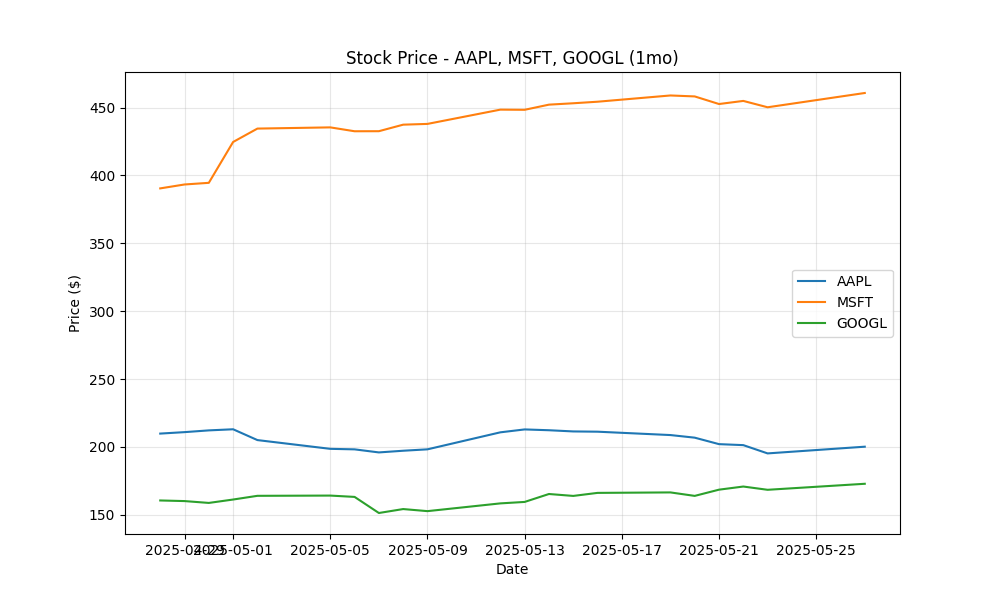


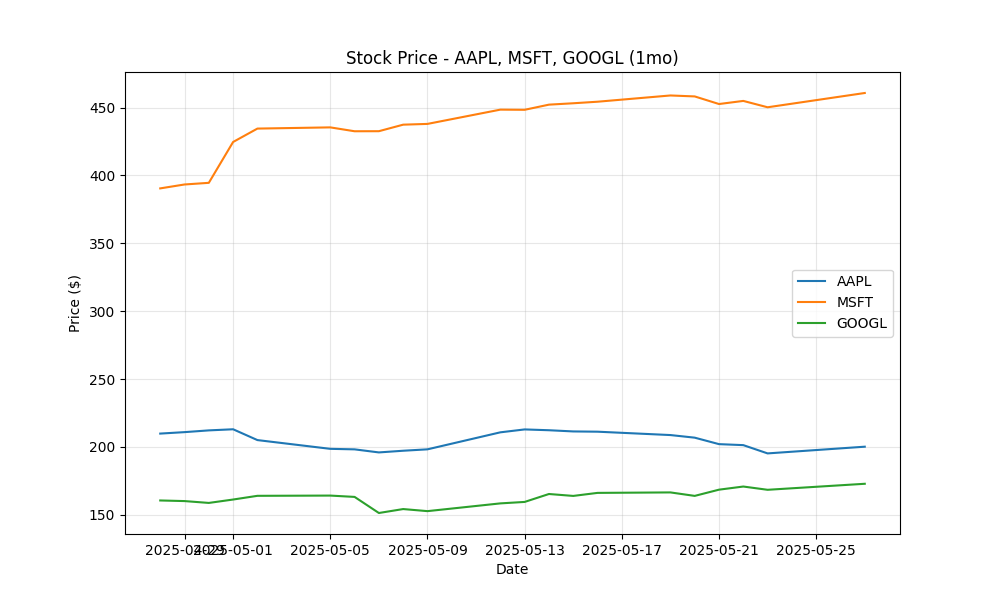

🛠️ Tool selected: generate_stock_chart
🔍 Parameters: {
  "symbols": [
    "AAPL",
    "MSFT",
    "GOOGL"
  ],
  "period": "1mo",
  "chart_type": "line"
}
🧠 Tool selection reasoning: I used the generate_stock_chart tool to visualize the stock prices of major tech companies. The chosen parameters allow for a comparison of the stock performance of AAPL, MSFT, and GOOGL over a 1-month period. I expect the line chart to display the stock price trends for these companies, enabling a straightforward comparison of their relative performance. This will help identify any notable patterns or divergences in their stock prices.
📊 Result: {'status': 'success', 'result': {'display_method': 'inline in notebook', 'symbols': ['AAPL', 'MSFT', 'GOOGL'], 'period': '1mo', 'type': 'line'}}
🧠 Reflection: The result provides a line chart comparing the stock performance of Apple (AAPL), Microsoft (MSFT), and Google (GOOGL) over the last month. By examining this chart, we can visually determine which stock perf


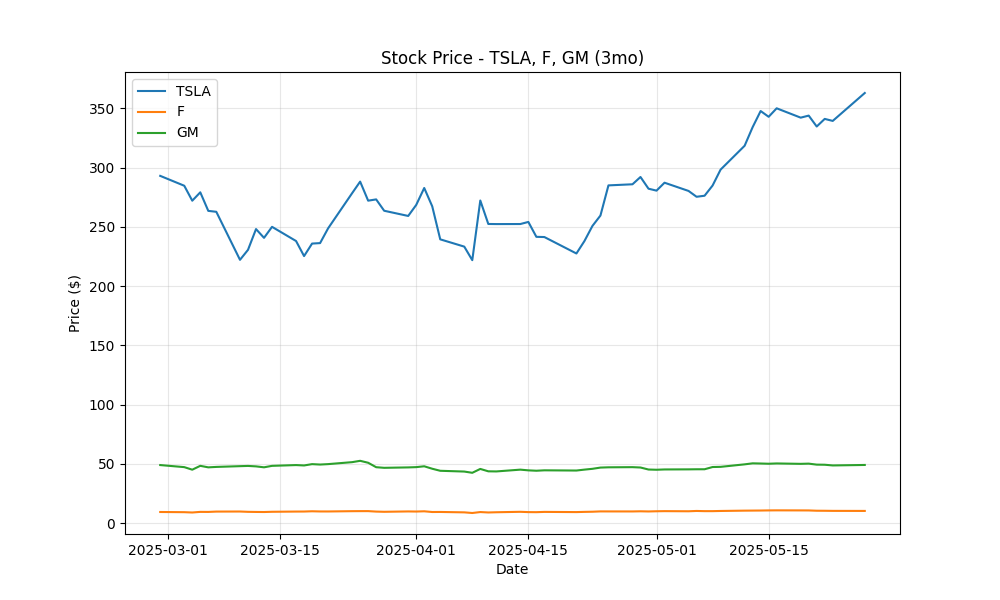


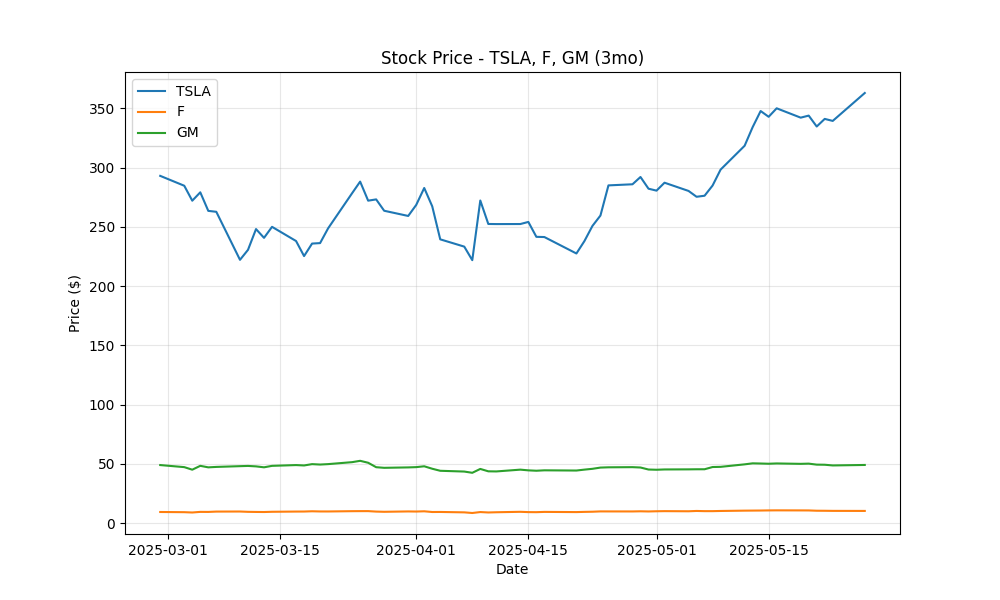


[Response 4]:
Here's a line chart comparing the stock performance of Tesla (TSLA), Ford (F), and General Motors (GM) over the last 3 months.

The chart effectively illustrates the relative performance of these three major automobile companies. As we previously discussed, Tesla (TSLA) has shown a significant increase, outperforming both Ford (F) and General Motors (GM) during this period.

When analyzing stock performance, it's crucial to consider various factors, including market trends, company performance, and broader economic conditions. While this chart provides valuable insights, it's essential to consult with a financial advisor before making any investment decisions.

If you're interested in exploring more stocks or discussing investment strategies, I'm here to help. Just let me know what you'd like to focus on next.

Response time: 4.53 seconds

📝 Conversation Summary:
The current price of Tesla (TSLA) is $362.89, and it has seen a 23.86% increase over the last 3 months. In co


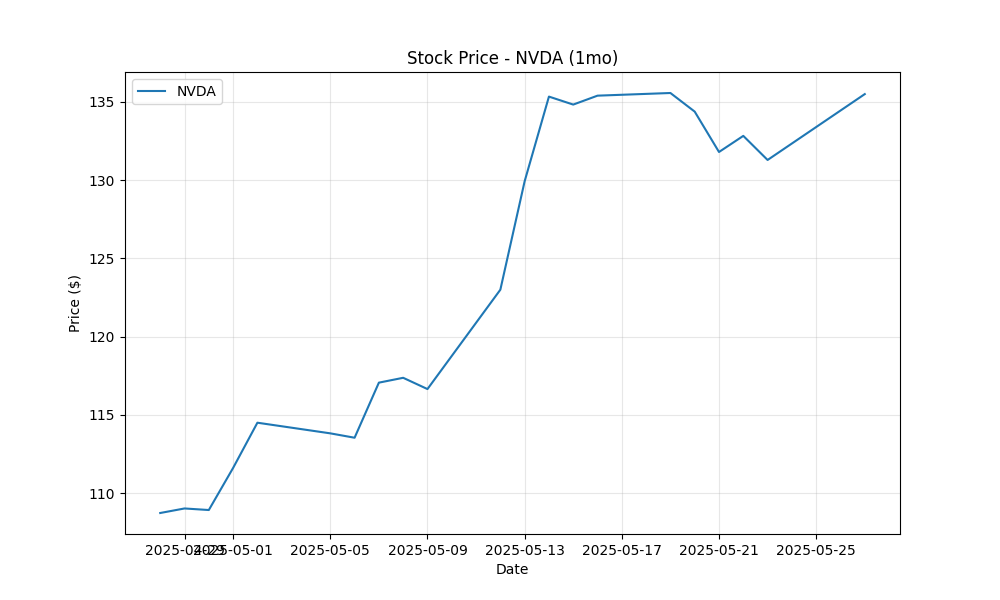

🔮 Running Monte Carlo simulation for NVDA (30 days, 1000 paths)...
✅ Simulation completed successfully!
📈 Current price: $135.50
📊 Mean predicted price: $141.94
🎯 Expected return: 4.75%
📉 90% confidence interval: $98.91 - $196.66

✅ Report:
**Nvidia Financial Prospects Report**

### Summary of Findings

Nvidia's stock price has shown significant growth over the past month, with a 24.62% increase. Our comprehensive analysis indicates a positive outlook for the company's financial prospects, driven by its strong fundamentals and market trends. However, the simulation results suggest a relatively high volatility, which investors should consider when making investment decisions.

### Price Trends and Fundamentals Analysis
-----------------------------------------

#### Price Trends

*   Nvidia's stock price has risen by 24.62% over the past month, reaching a latest price of $135.5.
*   The trading volume was 192,126,300 shares on the date of the analysis (2025-05-27).
*   The 52-week high 

In [27]:
if __name__ == "__main__":
    interactive_finance_demo()